# Preliminary

In [ ]:
# Check gpu runtime
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)
    ram_gb = virtual_memory().total / 1e9
    print('\n')
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [ ]:
# Time code cell execution
!pip install ipython-autotime
%load_ext autotime

In [ ]:
# Parameter tuning
!pip install ray[default]

In [ ]:
# Parameter tuning
!pip install tensorboardX

In [2]:
# Imports
from   functools import partial
from   google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   ray import tune
from   ray.tune import CLIReporter
from   ray.tune.schedulers import ASHAScheduler
from   sklearn.model_selection import train_test_split
import sys
import torch
import torch.nn as nn
from   torch.utils import data

In [3]:
# Plots
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [ ]:
# Google Drive
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/')

# Data

In [5]:
def load_data(datapoints='max', random_state=None):
    """
    Load examples from a csv file and create a training and testing dataset using
    a standard 80/20 split.

    Parameters
    ----------
    datapoints : int or str, default='max'
        Number of examples to load from the csv.
    random_state : int or None, default=None
        Controls the shuffling of data before being split. Pass a specific int
        for a reproducible split.

    Returns
    -------
    train_dataset : TensorDataset
        Dataset containing 80% of randomly selected examples from the csv.
    test_dataset : TensorDataset
        Dataset containing the remaining 20% of examples.
    """

    # Get data as dataframe
    df = pd.read_csv('/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model_input_duolingo_subset.csv')
    max_datapoints = len(df)

    # Optionally use a subset of data
    if datapoints != 'max':
        assert datapoints <= max_datapoints, f'max datapoints is {max_datapoints}'
        df = df[:datapoints]
    
    # Separate features and labels
    df_x = df.drop('p_trans', axis=1)
    df_y = df['p_trans'].to_frame()

    # Create feature and label tensors
    x = torch.tensor(df_x.values, dtype=torch.float32)
    y = torch.tensor(df_y.values, dtype=torch.float32)

    # Split data into testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(
        x, y,
        test_size=0.2,
        random_state=random_state)

    # Create datasets
    train_dataset = data.TensorDataset(X_train, y_train)
    test_dataset = data.TensorDataset(X_test, y_test)

    return train_dataset, test_dataset

In [6]:
train_dataset, test_dataset = load_data()
len(train_dataset)

587051

In [7]:
# First learning trace
next(iter(train_dataset))

(tensor([ 1.9851, -0.3607, -0.3607, -0.3607, -0.4276,  0.3376, -1.3243,  1.4815,
          0.7002,  0.8726]), tensor([0.8333]))

# Model

In [8]:
def init_weights(m):
    """Apply to a created model to initialise the weights and bias."""
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)

In [9]:
class LangyBlock(nn.Module):
    """
    A block for a LangyNet model consisting of:
    - linear hidden layer
    - rectified linear activation function
    - dropout layer.

    Initialisation Parameters
    -------------------------
    id : int
        Block identification number.
    input_nodes : int
        Input size for the hidden layer.
    output_nodes : int
        Output size for the hidden layer i.e. number of hidden nodes.
    p_dropout : float, default=0
        Probability of a hidden layer node to be zeroed.

    Forward Parameters
    ------------------
    x : Tensor
        Size([batch_size, input_nodes])

    Returns
    -------
    x : Tensor
        Size([batch_size, output_nodes])

    """

    def __init__(self, id, input_nodes, output_nodes, p_dropout=0):
        super(LangyBlock, self).__init__()
        self.id = id
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        self.p_dropout = p_dropout

        self.add_module(
            f'hid{self.id}',
            nn.Linear(self.input_nodes, self.output_nodes))
        self.add_module(
            f'act{self.id}',
            nn.ReLU())
        self.add_module(
            f'drop{self.id}',
            nn.Dropout(self.p_dropout))

    def forward(self, x):
        x = self._modules[f'hid{self.id}'](x)
        x = self._modules[f'act{self.id}'](x)
        x = self._modules[f'drop{self.id}'](x)
        return x

In [10]:
class LangyNet(nn.Module):
    """
    A neural network with a configurable number of hidden layers.

    Takes a Tensor of learning traces and produces a prediction for the
    probability that the represented foreign word can be correctly translated.

    Initialisation Parameters
    -------------------------
    hidden_layers : int
        Number of hidden layers i.e. LangyBlocks to use.
    hidden_nodes : int
        Number of nodes to use in hidden layers.
    p_dropout : float, default=0
        Probability of a hidden layer node to be zeroed.

    Forward Parameters
    ------------------
    x : Tensor
        Tensor of learning traces, Size([batch_size, 10])

    Returns
    -------
    p_trans : Tensor
        Probability of correct translation, Size([batch_size, 1])
    """

    def __init__(self, hidden_layers, hidden_nodes, p_dropout=0):
        super(LangyNet, self).__init__()
        self.input_features = 10  # delta, seen, ..., frn_4
        self.output_features = 1  # p_trans
        self.hidden_layers = hidden_layers
        self.hidden_nodes = hidden_nodes
        self.p_dropout = p_dropout

        # Add hidden layers
        for i in range(hidden_layers):
            if i == 0:
                # First hidden layer
                self.add_module(
                    f'langy_block_{i+1}',
                    LangyBlock(i+1, self.input_features, self.hidden_nodes, self.p_dropout))
            else:
                # Additional hidden layers
                self.add_module(
                    f'langy_block_{i+1}',
                    LangyBlock(i+1, self.hidden_nodes, self.hidden_nodes, self.p_dropout))
            
        # Output layer
        self.output = nn.Linear(self.hidden_nodes, self.output_features)
        

    def forward(self, x):
        for i in range(self.hidden_layers):
            x = self._modules[f'langy_block_{i+1}'](x)
        x = self.output(x)
        return x

In [13]:
# Example model initialisation
LangyNet(3, 16)

LangyNet(
  (langy_block_1): LangyBlock(
    (hid1): Linear(in_features=10, out_features=16, bias=True)
    (act1): ReLU()
    (drop1): Dropout(p=0, inplace=False)
  )
  (langy_block_2): LangyBlock(
    (hid2): Linear(in_features=16, out_features=16, bias=True)
    (act2): ReLU()
    (drop2): Dropout(p=0, inplace=False)
  )
  (langy_block_3): LangyBlock(
    (hid3): Linear(in_features=16, out_features=16, bias=True)
    (act3): ReLU()
    (drop3): Dropout(p=0, inplace=False)
  )
  (output): Linear(in_features=16, out_features=1, bias=True)
)

# Training Functions

The functions `train` and `tuning` use a dictionary of parameters, `config`, which must include the following:

1. `hidden_layers`: number of hidden layers to use
1. `hidden_nodes`: number of nodes to use in hidden layers
1. `p_dropout`: probability of a hidden layer node to be zeroed
1. `weight_decay`: penalty to apply to model weights
1. `learning_rate`: rate at which model weights are adjusted
1. `batch_size`: number of examples per batch
1. `epochs`: number of cycles through the full dataset

Below is an example of what a configuration may look like:

```
config = {
    'hidden_layers': 1,
    'hidden_nodes': 16,
    'p_dropout': 0,
    'weight_decay': 0,
    'learning_rate': 0.01,
    'batch_size': 64,
    'epochs': 200,
}
```

`train` uses `config` to train a single model with specific values for each parameter.

`tuning` uses `config` to perform distributed model training with a range of values for each parameter to find an optimal combination.

In [14]:
# https://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#classification-accuracy

class Accumulator:
    """For accumulating sums over `n` variables."""
    
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
def train_epoch(model, device, train_loader, loss_fn, optimiser):
    """
    Trains a model for a single epoch.

    Parameters
    ----------
    model : LangyNet
        The model to train.
    device : str
        For CPU/GPU processing, either 'cpu' or 'cuda:0'
    train_loader : DataLoader
        DataLoader which supplies examples from the training subset.
    loss_fn : torch.nn Loss Function
        Loss function to measure error between predictions and ground truth.
    optimiser : torch.optim.Optimizer
        Optimiser to update model parameters.
    
    Returns
    -------
    epoch_loss : float
        Loss of the model on training data after a single epoch.
    """

    if isinstance(model, torch.nn.Module):
        model.train()  # training mode

    metric = Accumulator(2)  # accumulate statistics over batches

    for X, y in train_loader:
        # CPU/GPU processing
        X, y = X.to(device), y.to(device)

        # Forward and backward pass
        optimiser.zero_grad()     # reset old gradients
        y_hat = model(X)          # compute prediction
        loss = loss_fn(y_hat, y)  # calculate loss
        loss.backward()           # calculate new gradients
        optimiser.step()          # update parameters

        # Statistics
        metric.add(
            float(loss.sum()),    # sum of training loss
            y.numel())            # number of examples

    return metric[0] / metric[1]  # training loss for epoch

In [16]:
def val_epoch(model, device, val_loader, loss_fn):
    """
    Performs model validation for a single epoch.

    Parameters
    ----------
    model : LangyNet
        The model to train.
    device : str
        For CPU/GPU processing, either 'cpu' or 'cuda:0'
    val_loader : DataLoader
        DataLoader which supplies examples from the validation subset.
    loss_fn : torch.nn Loss Function
        Loss function to measure error between predictions and ground truth.
    
    Returns
    -------
    val_loss : float
        Loss of the model on validation data after a single epoch.
    """

    if isinstance(model, torch.nn.Module):
        model.eval()  # evaluation mode

    metric = Accumulator(2)  # accumulate statistics over batches

    for X, y in val_loader:
        with torch.no_grad():
            # CPU/GPU processing
            X, y = X.to(device), y.to(device)

            # Computations
            y_hat = model(X)          # compute prediction
            loss = loss_fn(y_hat, y)  # calculate loss

            # Statistics
            metric.add(
                loss.cpu().numpy(),   # validation loss
                1)                    # validation steps
    
    return metric[0] / metric[1]

The main training function `train` makes use of both `train_epoch` and `val_epoch`.

It involves continually cycling the model between training and evaluation mode to produce a trained model.

In [24]:
def train(config, datapoints='max', random_state=None, verbose=True, tuning=False, checkpoint_dir=None):
    """
    Create, train and validate a model over epochs.

    Parameters
    ----------
    config : dictionary
        Parameters each with a single value.
    datapoints : int or str, default='max'
        Number of examples to train with from the data csv file.
    random_state : int or None, default=None
        Controls the shuffling of data before being split for training and
        testing. Pass a specific int for a reproducible split.
    verbose : bool, default=True
        Control whether to print config, model and loss while training.
    tuning : bool, default=False
        Control whether to use Ray for parameter tuning.
    checkpoint_dir : str, default=None
        Directory path to be used for checkpointing when parameter tuning.
    
    Returns
    -------
    model : LangyNet
        The trained model.
    history : dict of list of float
        History of training and validation loss.
    """

    # Initialise model
    model = LangyNet(
        config['hidden_layers'],
        config['hidden_nodes'],
        config['p_dropout'])
    model.apply(init_weights)
    if verbose:
        print('config:', config)
        print(model)

    # CPU/GPU processing
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # Split dataset for training and validation
    train_dataset, test_dataset = load_data(datapoints)
    train_size = int(len(train_dataset) * 0.8)  # 80%
    val_size = len(train_dataset) - train_size  # 20%
    train_subset, val_subset = data.random_split(
        train_dataset, [train_size, val_size])
    
    # Dataloaders
    train_loader = data.DataLoader(
        train_subset, config['batch_size'], shuffle=True)
    val_loader = data.DataLoader(
        val_subset, config['batch_size'], shuffle=True)

    # Loss and optimisation
    loss_fn = nn.MSELoss()
    optimiser = torch.optim.Adam(
        model.parameters(),
        weight_decay=config['weight_decay'],
        lr=config['learning_rate'])

    # Parameter tuning
    if checkpoint_dir:
        model_state, optimiser_state = torch.load(
            os.path.join(checkpoint_dir, 'checkpoint'))
        model.load_state_dict(model_state)
        optimiser.load_state_dict(optimiser_state)

    # Track loss history for plotting
    history = {
        'train_loss': [],
        'val_loss': []
    }

    # Loop over dataset
    for epoch in range(config['epochs']):
        # Train and validate model
        train_loss = train_epoch(model, device, train_loader, loss_fn, optimiser)
        val_loss = val_epoch(model, device, val_loader, loss_fn)

        # Track statistics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Display losses
        if verbose and (epoch == 0 or (epoch + 1) % 10 == 0):
            print(f'ep {(epoch + 1)  :<3} ',
                f'train_loss={train_loss:.8f} ',
                f'val_loss={val_loss:.8f}')
        
        # Hyperparameter tuning
        if tuning:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimiser.state_dict()), path)
            tune.report(loss=val_loss)
    
    return model, history

time: 57.6 ms (started: 2021-04-30 21:35:10 +00:00)


# Parameter Exploration

Please see the other notebook.

# Optimisation

Using Ray Tune to perform distributed training to produce the optimal configuration and model.

Tuning is performed with `datapoints='max'`, so each trialed model will "see" the **entire** training dataset.

Data is loaded with `random_state=1` for a reproducible train/test split.

## Tuning Function

In [25]:
def tuning(config, num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    """
    Perform distributed model training with a configured range of values for 
    each parameter in order to find an optimal combination for the lowest 
    validation loss.

    Parameters
    ----------
    config : dictionary
        Parameter search space to tune for.
    num_samples : int, default=10
        Number of times to sample from the search space. For example, for a grid
        search, num_samples=10 means every possible parameter combination is
        trialed 10 times.
    max_num_epochs : int, default=10
        Maximum time units per tuning trial.
    gpus_per_trial : int, default=1
        Number of GPUs to use per tuning trial.
    
    Returns
    -------
    best_trained_model : LangyNet
        A trained LangyNet model using optimised configuration.

    """

    load_data(random_state=1)

    # Tuning details
    scheduler = ASHAScheduler(
        metric='loss',
        mode='min',
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        metric_columns=['loss', 'training_iteration'])
    
    # Perform tuning
    result = tune.run(
        partial(train, random_state=1, verbose=False, tuning=True),
        resources_per_trial={'cpu': 2, 'gpu': gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    # Display optimal configuration
    best_trial = result.get_best_trial('loss', 'min', 'last')
    print(f'Best trial config: {best_trial.config}')
    print(f'Best trial final validation loss: {best_trial.last_result["loss"]}')

    # Initialise model with best config
    best_trained_model = LangyNet(
        best_trial.config['hidden_layers'],
        best_trial.config['hidden_nodes'],
        best_trial.config['p_dropout'])
    best_trained_model.apply(init_weights)
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    # Load model state
    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimiser_state = torch.load(os.path.join(
        best_checkpoint_dir, 'checkpoint'))
    best_trained_model.load_state_dict(model_state)

    return best_trained_model

time: 26.7 ms (started: 2021-04-30 21:35:55 +00:00)


## Grid Search

Perform tuning with a specific search space, exhaustively trialing every possible combination of configured hyperparameters.

`tune.grid_search` will exhaustively tune using each configured option. Other hyperparameters are given a single explicit option to use.

`num_samples=10` means every possible parameter combination is trialed 10 times.



### Perform Search

In [ ]:
# Values are chosen as a result of parameter exploration
# See Parameter Exploration.ipynb

# Parameter search space
config = {
    'hidden_nodes': tune.grid_search([16, 64, 96]),
    'hidden_layers': tune.grid_search([2, 3]),
    'p_dropout': 0,
    'weight_decay': 0,
    'learning_rate': 0.001,
    'batch_size': 128,
    'epochs': 200,  
}

grid_search_model = tuning(config, num_samples=10)

```
Best trial config: {'hidden_nodes': 16, 'hidden_layers': 3, 'p_dropout': 0, 'weight_decay': 0, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200}
Best trial final validation loss: 8.385678520393956e-07
```

### Save Model

In [20]:
# Save state dict
DICT_PATH = '/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model_state_dict.pt'

torch.save(
    grid_search_model.state_dict(),
    DICT_PATH)

In [ ]:
# Display state (weights and bias)
for param_tensor in grid_search_model.state_dict():
    print(param_tensor, '\n', grid_search_model.state_dict()[param_tensor])

In [21]:
# Save entire model
MODEL_PATH = '/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model.pt'

torch.save(
    grid_search_model,
    MODEL_PATH)

In [48]:
# Save the first block
BLOCK_PATH = '/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model_block.pt'

torch.save(
    grid_search_model.langy_block_1,
    BLOCK_PATH)

time: 241 ms (started: 2021-04-30 23:06:24 +00:00)


### Best Results

Below shows the top 11 configurations from the grid search, ordered by least validation loss to highest.

These are configurations of models which achieved a final validation loss below 1e-4 (0.0001).

Where parameter exploration could not conclusively identify the best choice for some parameters, these results reveal that the most performant models tend to use 3 hidden layers and 16 hidden nodes.

```
+---------------------+------------+-------+-----------------+----------------+-------------+----------------------+
| Trial name          | status     | loc   |   hidden_layers |   hidden_nodes |        loss |   training_iteration |
|---------------------+------------+-------+-----------------+----------------+-------------+----------------------|
| DEFAULT_19ab8_00013 | TERMINATED |       |               3 |             16 | 8.38568e-07 |                   10 |
| DEFAULT_19ab8_00017 | TERMINATED |       |               3 |             16 | 1.44506e-06 |                   10 |
| DEFAULT_19ab8_00000 | TERMINATED |       |               2 |             16 | 2.04410e-06 |                   10 |
| DEFAULT_9f8f3_00000 | TERMINATED |       |               2 |             16 | 2.82208e-06 |                   10 |
| DEFAULT_19ab8_00009 | TERMINATED |       |               3 |             16 | 8.57765e-06 |                    8 |
| DEFAULT_9f8f3_00035 | TERMINATED |       |               3 |             96 | 1.24422e-05 |                   10 |
| DEFAULT_9f8f3_00021 | TERMINATED |       |               3 |             64 | 1.28993e-05 |                    8 |
| DEFAULT_9f8f3_00033 | TERMINATED |       |               3 |             64 | 1.29682e-05 |                    8 |
| DEFAULT_19ab8_00033 | TERMINATED |       |               3 |             16 | 1.59302e-05 |                    4 |
| DEFAULT_19ab8_00025 | TERMINATED |       |               3 |             16 | 2.65368e-05 |                    8 |
| DEFAULT_19ab8_00011 | TERMINATED |       |               3 |             64 | 4.82185e-05 |                    4 |
+---------------------+------------+-------+-----------------+----------------+-------------+----------------------+
```

### Optimal Configuration

In [28]:
config_optimal = {
    'hidden_layers': 3,
    'hidden_nodes': 16,
    'p_dropout': 0,
    'weight_decay': 0,
    'learning_rate': 0.001,
    'batch_size': 128,
    'epochs': 200,
}

time: 2 ms (started: 2021-04-30 22:25:51 +00:00)


<!-- ![LangyNet Architecture](https://drive.google.com/uc?export=view&id=1ueaNc5Rjrpt-kU8ZbaPG-7QIM_TpfoLY) -->

## Loss Comparison

Compare loss of two LangyNet models:
- `model_base`: using **baseline** configuration, same as in Parameter Exploration notebook
- `model_opt`: using **optimal** configuration, found through grid search

Consistent across models:
- `epochs: 200`
- trained using the same random subset of 20,000 examples

Note that:
- A subset of examples is not necessarily representative of the complete dataset.
- A subset was used to decrease training time for comparative purposes.
- The models being trained here are only for comparative purposes and will not be used further.

### Configurations

In [75]:
# Baseline configuration
config_base = {
    'hidden_layers': 1,
    'hidden_nodes': 16,
    'p_dropout': 0,
    'weight_decay': 0,
    'learning_rate': 0.01,
    'batch_size': 64,
    'epochs': 200,
}

# Optimal configuration
config_optimal = {
    'hidden_layers': 3,
    'hidden_nodes': 16,
    'p_dropout': 0,
    'weight_decay': 0,
    'learning_rate': 0.001,
    'batch_size': 128,
    'epochs': 200,
}

time: 4.15 ms (started: 2021-05-01 00:12:36 +00:00)


### Training

In [ ]:
model_base, history_base, = train(
    config_base,
    datapoints=20000,
    random_state=1)

In [ ]:
model_opt, history_opt, = train(
    config_optimal,
    datapoints=20000,
    random_state=1)

### Plot: Training Loss

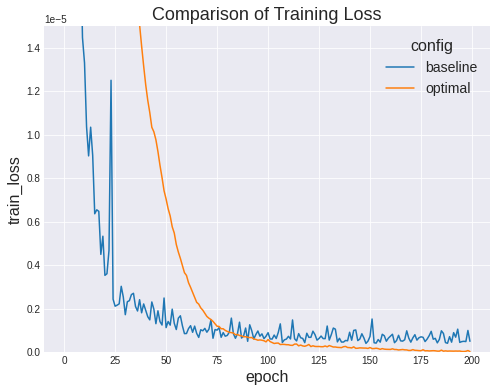

time: 203 ms (started: 2021-04-30 23:36:00 +00:00)


In [54]:
plt.figure(figsize=(8, 6))
plt.title('Comparison of Training Loss', fontsize=18)
plt.plot(history_base['train_loss'], label='baseline')
plt.plot(history_opt['train_loss'], label='optimal')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('train_loss', fontsize=16)
plt.ylim(0, 0.000015)
plt.legend(
    title='config',
    title_fontsize=16,
    fontsize=14,
    loc='upper right')
plt.show()

### Plot: Validation Loss

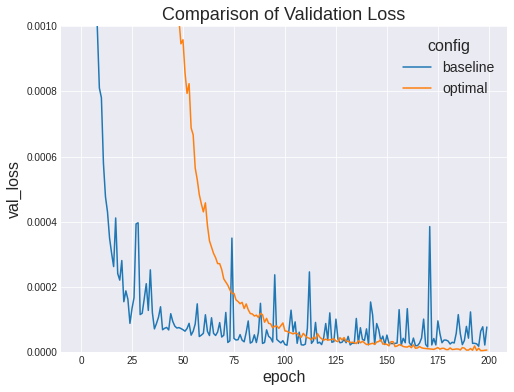

time: 191 ms (started: 2021-04-30 23:40:37 +00:00)


In [60]:
plt.figure(figsize=(8, 6))
plt.title('Comparison of Validation Loss', fontsize=18)
plt.plot(history_base['val_loss'], label='baseline')
plt.plot(history_opt['val_loss'], label='optimal')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('val_loss', fontsize=16)
plt.ylim(0, 0.001)
plt.legend(
    title='config',
    title_fontsize=16,
    fontsize=14,
    loc='upper right')
plt.show()

**Spikes in validation loss** are expected and are a consequence of training with some form of stochastic or mini-batch gradient descent.

Training is performed over epochs, each of which involves pass over the complete dataset. Here we train using mini-batches of data, with an epoch of training requiring several steps to process all mini-batches.

Each step involves selecting a number of examples = batch_size, computing a prediction, calculating loss, then updating the model. A spike occurs when a model update increases the loss due to the particular examples seen, rather than decreasing it. The model cannot generalise as well for the examples in this mini-batch compared to those from the previous.

Sources:
- [Batch, Mini Batch & Stochastic Gradient Descent](https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a)
- [Doubts regarding training loss, validation loss and number of epochs](https://forums.fast.ai/t/doubts-regarding-training-loss-validation-loss-and-number-of-epochs/60734/2)
- [Explanation of Spikes in training loss vs. iterations with Adam Optimizer](https://stats.stackexchange.com/a/304150)
- [Why does the loss/accuracy fluctuate during the training?](https://stats.stackexchange.com/a/384995)



# Testing

## Testing Function

In [55]:
def test(model, batch_size=128, verbose=True):
    """
    Tests a model.

    Parameters
    ----------
    model : LangyNet
        The model to test.
    batch_size : int, default=128
        Number of examples per batch.
    verbose : bool, default=True
        Control whether to print loss while testing.
    
    Returns
    -------
    test_loss : list of float
        History of testing loss.
    min : float
        Minimum testing loss of a single batch.
    max : float
        Maximum testing loss of a single batch.
    avg : float
        Average testing loss across all batches.
    """

    if isinstance(model, torch.nn.Module):
        model.eval()  # evaluation mode

    # CPU/GPU processing
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # Ensure we test on unseen data
    # random_state=1 used by tuning function to produce model
    train_dataset, test_dataset = load_data(random_state=1)
    test_loader = data.DataLoader(test_dataset, batch_size, shuffle=True)
    if verbose:
        print(f'Testing dataset contains {len(test_dataset)} examples.\n'
              f'Batch size set to {batch_size}.\n')

    # Calculate and track loss
    loss_fn = nn.MSELoss()
    test_loss = []
    min, max = 0, 0

    for batch, (X, y) in enumerate(test_loader):
        with torch.no_grad():
            # CPU/GPU processing
            X, y = X.to(device), y.to(device)

            # Computations
            y_hat = model(X)          # compute prediction
            loss = loss_fn(y_hat, y)  # calculate loss

            # Track batch loss
            # sum of testing loss / number of examples
            batch_loss = float(loss.sum()) / y.numel()
            test_loss.append(batch_loss)
            if batch == 0:
                min, max = batch_loss, batch_loss
            else:
                if batch_loss < min: min = batch_loss
                if batch_loss > max: max = batch_loss

            # Display loss
            if verbose and (batch == 0 or (batch + 1) % 100 == 0):
                print(f'batch {batch+1 :<4} ',
                      f'test_loss={batch_loss:.11f}')

    avg = sum(test_loss) / len(test_loss)
    if verbose:
        print('\n\n',
              f'min={min:.11f} ({min})\n',
              f'max={max:.11f} ({max})\n',
              f'avg={avg:.11f} ({avg})\n')

    return test_loss, min, max, avg

time: 44.6 ms (started: 2021-04-30 23:36:59 +00:00)


## Load Model

In [69]:
MODEL_PATH = '/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model.pt'
DICT_PATH = '/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model_state_dict.pt'

# CPU/GPU processing
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'

model = torch.load(MODEL_PATH)
model.to(device)
model.eval()

LangyNet(
  (langy_block_1): LangyBlock(
    (hid1): Linear(in_features=10, out_features=16, bias=True)
    (act1): ReLU()
    (drop1): Dropout(p=0, inplace=False)
  )
  (langy_block_2): LangyBlock(
    (hid2): Linear(in_features=16, out_features=16, bias=True)
    (act2): ReLU()
    (drop2): Dropout(p=0, inplace=False)
  )
  (langy_block_3): LangyBlock(
    (hid3): Linear(in_features=16, out_features=16, bias=True)
    (act3): ReLU()
    (drop3): Dropout(p=0, inplace=False)
  )
  (output): Linear(in_features=16, out_features=1, bias=True)
)

time: 12.4 ms (started: 2021-04-30 23:52:51 +00:00)


In [ ]:
# # Alternatively, load model by using state dict

# # Initialise model
# model = LangyNet(
#     hidden_layers=3,
#     hidden_nodes=16,
#     p_dropout=0)

# # Load state
# model.load_state_dict(torch.load(
#     DICT_PATH,
#     map_location=torch.device(device)))

# # Set model to evaluation mode
# model.eval()

## Perform Testing

In [70]:
test_loss, min, max, avg = test(model)

Testing dataset contains 146763 examples.
Batch size set to 128.

batch 1     test_loss=0.00000000791
batch 100   test_loss=0.00000000637
batch 200   test_loss=0.00000000554
batch 300   test_loss=0.00000000647
batch 400   test_loss=0.00000000589
batch 500   test_loss=0.00000000619
batch 600   test_loss=0.00000000556
batch 700   test_loss=0.00000000744
batch 800   test_loss=0.00000000674
batch 900   test_loss=0.00000000559
batch 1000  test_loss=0.00000000571
batch 1100  test_loss=0.00000000537


 min=0.00000000343 (3.4347957811320384e-09)
 max=0.00000001197 (1.197352705872845e-08)
 avg=0.00000000651 (6.506995128693266e-09)

time: 3 s (started: 2021-04-30 23:52:55 +00:00)


## Plot: Testing Loss

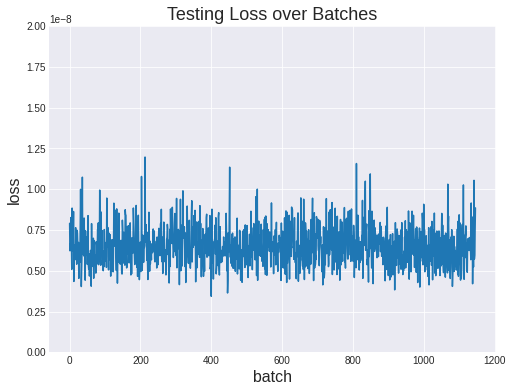

time: 192 ms (started: 2021-04-30 23:54:38 +00:00)


In [74]:
plt.figure(figsize=(8, 6))
plt.title('Testing Loss over Batches', fontsize=18)
plt.plot(test_loss)
plt.xlabel('batch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.ylim(0, 0.00000002)
plt.show()